# First deep learning approach second challenge

In [ ]:
import sys
import os
sys.path.append(os.path.abspath("../code/")) #Add parent directory
from modules.utils import set_seed

SEED = 42
set_seed(SEED)

# Libraries

In [2]:
import torch
import numpy as np
from modules.data_loader import get_data_loaders
from modules.models_pretrained import SkinLesionClassifier
from modules.train import train_model
from modules.utils import calculate_accuracy
from modules.visualize_aug import visualize_dataloader
from modules.plot_losses import plot_losses

# Connect to GPU

In [3]:
print(torch.cuda.is_available())
print(torch.cuda.get_device_name(0))

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Device: {device}")

True
NVIDIA GeForce RTX 4060 Laptop GPU
Device: cuda


# Hyperparameters

In [4]:
batch_size = 64
num_epochs = 10
learning_rate = 0.0001
train_dir = r"C:\Users\User\Desktop\UDG_old_pc\UDG\Subjects\Computer_Aided_Diagnosis\Labs\Datasets\train\train".replace("\\", "/")
val_dir = r"C:\Users\User\Desktop\UDG_old_pc\UDG\Subjects\Computer_Aided_Diagnosis\Labs\Datasets\val\val".replace("\\", "/")

# Load data

In [5]:
train_loader, val_loader = get_data_loaders(train_dir, val_dir, batch_size)

mean = np.array([0.485, 0.456, 0.406])
std = np.array([0.229, 0.224, 0.225])

class_train = train_loader.dataset.classes
class_val = val_loader.dataset.classes

print(f"Train classes {class_train}")
print(f"Val classes: {class_val}")

Train classes ['nevus', 'others']
Val classes: ['nevus', 'others']


Type of images: <class 'torch.Tensor'>
Type of labels: <class 'torch.Tensor'>
Type of paths: <class 'tuple'>


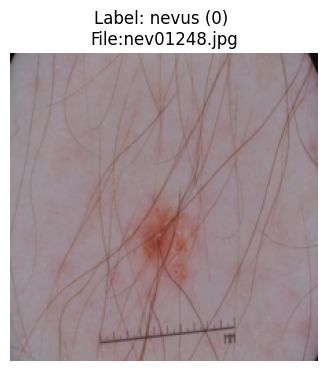

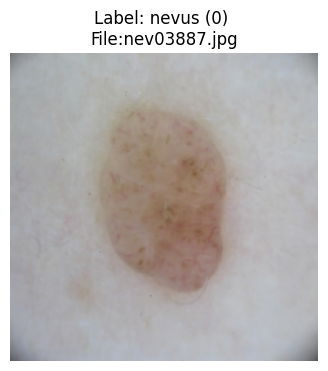

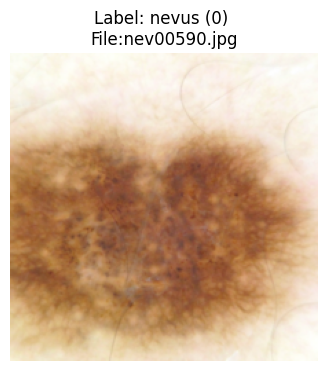

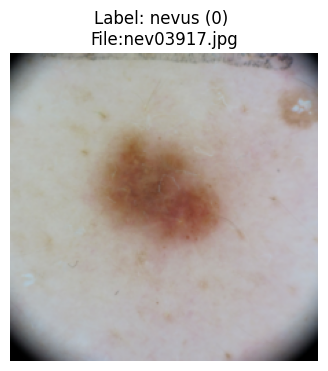

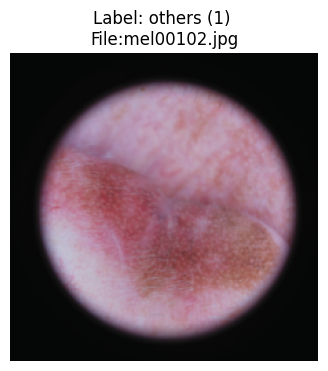

In [6]:
visualize_dataloader(train_loader, mean, std, 5)

# Initialize model

In [7]:
#Initialize model
model = SkinLesionClassifier(num_classes=1)

## Loss and optimizerv

Recommended settings for *scheduler*:
* mode='min' (to minimize validation loss).
* patience=3 (adjust based on how quickly your model stabilizes).
* factor=0.1 (reduce the learning rate by 10x when triggered).

In [8]:
criterion = torch.nn.BCEWithLogitsLoss() #tHE OTHER ONE EXPECTS THE INPUT TO BE PASSED THROUGH A LOGIT BEFORE
optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate, weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=2, gamma = 0.01) #Reduces the Lr by gamma every step_size epochs

#Other schedulers
#scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma = 0.9)
#scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode = 'min', patience = 2, factor = 0.1, verbose = True)

## Train the model

Some possible things to fix regarding the small fluctations:
 1) Learning rate: if it is too high, it could cause instability in optimization
 2) Validation Data Variance: Some inherit noise
 3) Optimization

# Generalization GAP

Epoch 1 / 10 Training Loss: 0.3941 Training Accuracy: 0.8238 Validation Loss: 0.3419 Validation Accuracy: 0.8506
Epoch 2 / 10 Training Loss: 0.2893 Training Accuracy: 0.8760 Validation Loss: 0.3169 Validation Accuracy: 0.8633
Epoch 3 / 10 Training Loss: 0.2295 Training Accuracy: 0.9046 Validation Loss: 0.3019 Validation Accuracy: 0.8720
Epoch 4 / 10 Training Loss: 0.2171 Training Accuracy: 0.9109 Validation Loss: 0.2962 Validation Accuracy: 0.8746
Epoch 5 / 10 Training Loss: 0.2120 Training Accuracy: 0.9127 Validation Loss: 0.2925 Validation Accuracy: 0.8733
Epoch 6 / 10 Training Loss: 0.2095 Training Accuracy: 0.9134 Validation Loss: 0.2954 Validation Accuracy: 0.8699
Epoch 7 / 10 Training Loss: 0.2110 Training Accuracy: 0.9142 Validation Loss: 0.2940 Validation Accuracy: 0.8733
Epoch 8 / 10 Training Loss: 0.2123 Training Accuracy: 0.9115 Validation Loss: 0.2969 Validation Accuracy: 0.8730
Epoch 9 / 10 Training Loss: 0.2106 Training Accuracy: 0.9144 Validation Loss: 0.2944 Validation 

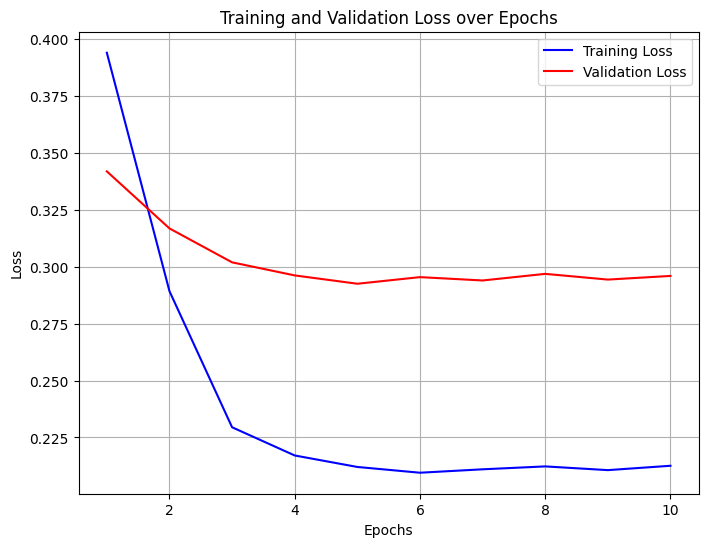

In [9]:
model, train_losses, val_losses = train_model(model,  train_loader, val_loader, criterion, optimizer, scheduler, num_epochs, device)

plot_losses(train_losses, val_losses)

# Testing on test set with our valius from previous challenge

In [12]:
import importlib
import modules.data_loader

importlib.reload(modules.data_loader)

<module 'modules.data_loader' from 'c:\\Users\\User\\GitHub_Projects\\CAD_DL\\CADx-Project\\2_DL\\code\\modules\\data_loader.py'>

In [13]:
test_path = fr"C:\Users\User\Desktop\UDG_old_pc\UDG\Subjects\Computer_Aided_Diagnosis\Labs\Datasets\test\testX".replace("\\", "/")
test_loader = modules.data_loader.get_data_loader_test(test_path, batch_size)

mean = np.array([0.485, 0.456, 0.406])
std = np.array([0.229, 0.224, 0.225])

class_test = test_loader.dataset.classes

print(f"Test classes: {class_test}")

Test classes: ['class_0', 'class_1']


Type of images: <class 'torch.Tensor'>
Type of labels: <class 'torch.Tensor'>
Type of paths: <class 'tuple'>


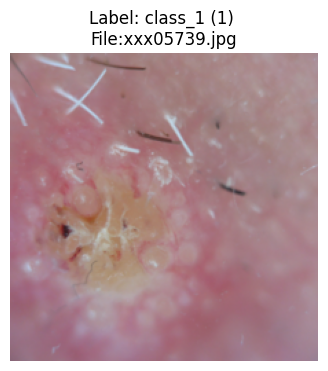

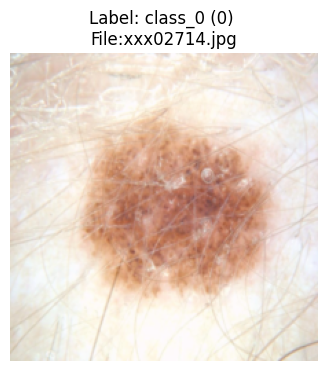

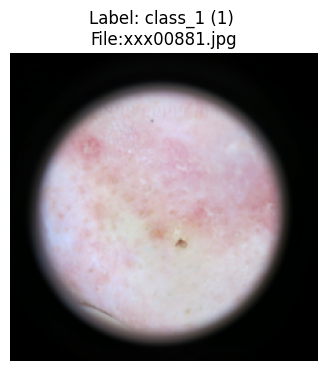

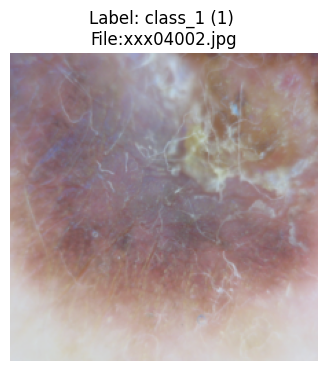

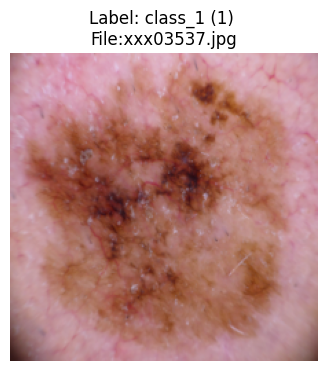

In [14]:
visualize_dataloader(test_loader, mean, std, 5)

# Eval

In [ ]:
model.eval()
predictions = []
labels = []

with torch.no_grad():
    for inputs, targets, _ in test_loader:
        inputs, targets = inputs.to(device), targets.to(device).float()
        outputs = model(inputs)

        preds = (torch.sigmoid(outputs) > 0.5).float()
        predictions.extend(preds.cpu().numpy())
        labels.extend(targets.cpu().numpy())



In [20]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

Accuracy: 0.8744
              precision    recall  f1-score   support

         0.0       0.86      0.90      0.88      3207
         1.0       0.89      0.85      0.87      3133

    accuracy                           0.87      6340
   macro avg       0.88      0.87      0.87      6340
weighted avg       0.88      0.87      0.87      6340



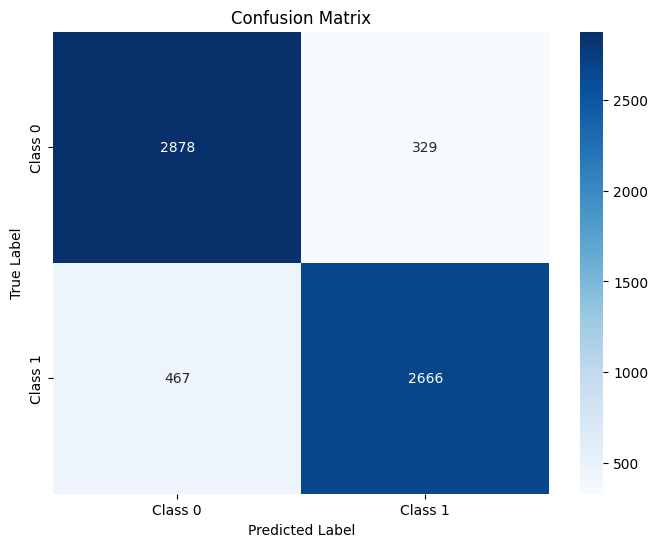

In [22]:
cm = confusion_matrix(labels, predictions)
accuracy = accuracy_score(labels, predictions)
print(f"Accuracy: {accuracy:.4f}")

print(classification_report(labels, predictions))

plt.figure(figsize = (8,6))
sns.heatmap(cm, annot= True, fmt = 'd', cmap = 'Blues', xticklabels=["Class 0", "Class 1"], yticklabels=["Class 0", "Class 1"])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title("Confusion Matrix")
plt.show()